In [2]:
%load_ext autoreload
%autoreload 2

# Imports


In [1]:

from bioreaction.simulation.manager import simulate_steady_states
from functools import partial
from typing import Optional, Tuple, List
from datetime import datetime
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'gpu')
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.70"

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


root_dir = '..'

In [4]:
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.data.data_format_tools.manipulate_fasta import load_seq_from_FASTA
from synbio_morpher.utils.evolution.evolver import Evolver
from synbio_morpher.utils.evolution.mutation import implement_mutation, apply_mutation_to_sequence, get_mutation_type_mapping, reverse_mut_mapping
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.misc.numerical import add_recursively
from synbio_morpher.utils.misc.helper import vanilla_return
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.results.writer import DataWriter
from synbio_morpher.srv.io.loaders.circuit_loader import load_circuit
from synbio_morpher.srv.io.manage.script_manager import script_preamble

# Find good starting circuits


## Load data


In [5]:
og_dir = '../data/ensemble_mutation_effect_analysis/2023_07_15_192831/generate_species_templates'
fn = '../data/ensemble_mutation_effect_analysis/2023_07_17_105328/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
data['mutation_type'] = data['mutation_type'].str.strip('[]').str.split(',').apply(lambda x: [int(xx) for xx in x if xx])
data['mutation_positions'] = data['mutation_positions'].str.strip('[]').str.split(',').apply(lambda x: [int(xx) for xx in x if xx])

### Modify original config file for running the sim

In [6]:
config = load_json_as_dict(os.path.join(fn.split('summarise')[
                           0], 'mutation_effect_on_interactions_signal', 'experiment.json'))
config = config['config_filepath']
config['experiment']['purpose'] = 'tests'
config['simulation']['device'] = 'gpu'


## Select starting candidates

We want to start with a circuit that has high adaptability, so a circuit that has high signal sensitivity and precision. We'll use the non-signal species $RNA_1$ and $RNA_2$ as the outputs.

One thing to look out for is that because precision is often then inverse of sensitivity, it will be much larger typically, so selecting the largest for both should give preference to sensitivity.


In [8]:
signal_species = config['signal']['inputs']

filt = (
    (data[get_true_interaction_cols(data, 'energies')].sum(axis=1) != 0) &
    (data['sample_name'].isin(signal_species) != True) &
    (data['overshoot'] > 0)
)

percentile = 0.9
sensitivity_range = data[filt]['sensitivity_wrt_species-6'] > (data[filt]['sensitivity_wrt_species-6'].max() *
                                                               percentile)
starting_circ_rows = data[filt][sensitivity_range].sort_values(
    by=['sensitivity_wrt_species-6', 'precision_wrt_species-6'], ascending=False)

print(
    f'Picking circuits that have a sensitivity in the {percentile * 100}th percentile of at least {data[filt]["sensitivity_wrt_species-6"].max() * percentile}')

len(starting_circ_rows)

Picking circuits that have a sensitivity in the 90.0th percentile of at least 0.36505494


13

Plot the starting candidates.

Text(0, 0.5, 'Precision')

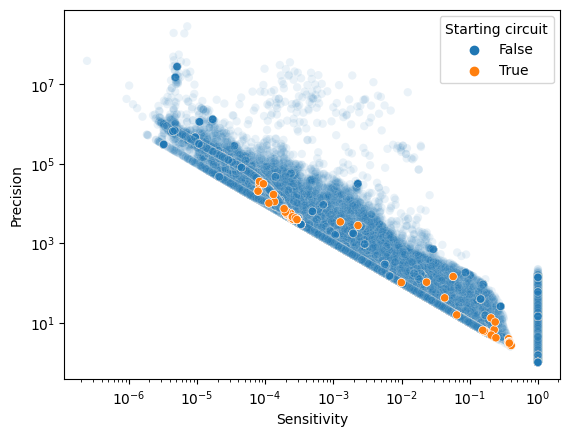

In [9]:

data['Starting circuit'] = (data['circuit_name'].isin(starting_circ_rows['circuit_name'])) & \
    (data['mutation_name'].isin(starting_circ_rows['mutation_name'])) & filt

sns.scatterplot(
    data.sort_values(by='Starting circuit'), x='sensitivity_wrt_species-6', y='precision_wrt_species-6',
    hue='Starting circuit', alpha=((data.sort_values(by='Starting circuit')['Starting circuit'] + 0.1)/1.1)
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sensitivity')
plt.ylabel('Precision')

In [10]:
data[data['Starting circuit']].sort_values(by='sensitivity_wrt_species-6', ascending=False)['sensitivity_wrt_species-6']

1042709    0.405617
377023     0.392066
1099279    0.383694
1458932    0.382633
1037908    0.381519
             ...   
1042808    0.000093
1042994    0.000083
1042795    0.000082
73412      0.000079
73411      0.000079
Name: sensitivity_wrt_species-6, Length: 63, dtype: float64

# Monte Carlo optimisation

We want to push circuits into ranges of higher sensitivity


## Optimisation function


In [11]:
s_target = 1
p_target = 10

def loss_func(s0, p0, s1, p1):
    
    dp = p1 - p0
    ds = s1 - s0
    
    return ds, dp

## Optimisation loop


### Initialise and set up run

In [12]:
config['mutations_args'] = {
    'algorithm': 'random',
    'mutation_counts': 2,
    'mutation_nums_within_sequence': [1],
    'mutation_nums_per_position': 1,
    'concurrent_species_to_mutate': 'single_species_at_a_time',
    'seed': 0
}
config['simulation']['dt0'] = config['simulation']['dt']
config['simulation']['threshold_steady_states'] = 0.1
config['experiment']['no_numerical'] = False
config['experiment']['no_visualisations'] = True

In [13]:
config, data_writer = script_preamble(prepare_config(config))

modeller = CircuitModeller(data_writer, config)
evolver = Evolver(data_writer, mutation_type='random', sequence_type='RNA', seed=0)

### Sim funcs

In [15]:


def mutate(circuits: list, evolver: Evolver, algorithm: str = 'random'):
    
    for c in circuits:
        c = evolver.mutate(
            c, write_to_subsystem=True, algorithm=algorithm)

    return circuits


def simulate(circuits: list, modeller: CircuitModeller, config: dict) -> list:
    
    circuits = modeller.batch_circuits(
        circuits=circuits,
        write_to_subsystem=True,
        batch_size=config['simulation'].get('batch_size', 100),
        methods={
            "compute_interactions": {},
            "init_circuits": {'batch': True},
            "simulate_signal_batch": {'ref_circuit': None,
                                      'batch': config['simulation']['use_batch_mutations']},
            "write_results": {'no_visualisations': config['experiment']['no_visualisations'],
                              'no_numerical': config['experiment']['no_numerical']}
        }
    )
    
    return circuits

    

### Helper funcs

In [16]:


def load_all_analytics(circuit_dirs):
    """ Top (starting) directory should be the starting circuit for each round """
    
    fbn = 'report_signal.json'
    circuits = {}
    for circuit_dir in circuit_dirs:
        if 'mutations' in os.listdir(circuit_dir):
            circuits[os.path.basename(circuit_dir)] = load_all_analytics(
                [os.path.join(circuit_dir, sc) for sc in os.listdir(circuit_dir)]) 
            circuits[os.path.basename(circuit_dir)]['ref_circuit'] = load_json_as_dict(
                os.path.join(circuit_dir, fbn))
        else:
            circuits[os.path.basename(circuit_dir)] = load_json_as_dict(os.path.join(circuit_dir, fbn))
    return circuits

def make_next_name(name: str):
    special_char = '_N_'
    return name.split(special_char)[0] + special_char + ''.join(str(datetime.now()).replace('.', '').split(':')[1:])



### Choosing next circuit

In [23]:

def choose_next(batch: list, data_writer, choose_max: int = 4, target_species: List[str] = ['RNA_1', 'RNA_2']):
    
    def make_data(batch, batch_analytics, target_species: List[str]):
        d = pd.DataFrame(
            data=np.concatenate(
                [
                    np.asarray([c.name for c in batch])[:, None],
                    np.asarray([c.subname for c in batch])[:, None]
                ], axis=1
            ),
            columns=['Name', 'Subname']
        )
        d['Circuit Obj'] = batch
        species_names = [s.name for s in batch[0].model.species]
        t_idxs = {s: species_names.index(s) for s in species_names if s in target_species}
        for t in target_species:
            t_idx = t_idxs[t]
            d[f'Sensitivity species-{t}'] = np.asarray([b['sensitivity_wrt_species-6'][t_idx] for b in batch_analytics])
            d[f'Precision species-{t}'] = np.asarray([b['precision_wrt_species-6'][t_idx] for b in batch_analytics])
        return d
        
    scale_sensitivity = 1
    scale_precision = 1
    batch_analytics = [load_json_as_dict(os.path.join(data_writer.top_write_dir, c.name, 'report_signal.json')) for c in batch]
    batch_analytics = jax.tree_util.tree_map(lambda x: np.float32(x), batch_analytics)
    data_1 = make_data(batch, batch_analytics, target_species)
    
    rs = data_1[data_1['Subname'] == 'ref_circuit']
    for t in target_species:
        data_1[f'Parent Sensitivity species-{t}'] = jax.tree_util.tree_map(lambda n: rs[rs['Name'] == n][f'Sensitivity species-{t}'].iloc[0], data_1['Name'].to_list())
        data_1[f'Parent Precision species-{t}'] = jax.tree_util.tree_map(lambda n: rs[rs['Name'] == n][f'Precision species-{t}'].iloc[0], data_1['Name'].to_list())
    
        data_1[f'dS species-{t}'] = data_1[f'Sensitivity species-{t}'] - data_1[f'Parent Sensitivity species-{t}']
        data_1[f'dP species-{t}'] = data_1[f'Precision species-{t}'] - data_1[f'Parent Precision species-{t}']
    
    t = target_species[0]
    circuits_chosen = data_1[(data_1[f'dS species-{t}'] >= 0) & (data_1[f'dP species-{t}'] >= 0)].sort_values(by=[f'Sensitivity species-{t}', f'Precision species-{t}'], ascending=False)['Circuit Obj'].iloc[:choose_max].to_list()
    data_1['Next selected'] = data_1['Circuit Obj'].isin(circuits_chosen)
    return circuits_chosen, data_1


### Process mutations between runs

In [18]:


def get_mutated_sequences(path, circ_row, mutation_type_mapping) -> dict:
    
    if not os.path.isfile(path):
        path = os.path.join(root_dir, path)
        assert os.path.isfile(path), f'Path {path} is not valid.'
    
    if circ_row['mutation_name'] == 'ref_circuit': 
        return path

    sequences = load_seq_from_FASTA(path, as_type = 'dict')
    mutated_species = circ_row['mutation_name'][:5]
    mutation_types = jax.tree_util.tree_map(lambda x: mutation_type_mapping[x], circ_row['mutation_type'])
    mutated_sequence = apply_mutation_to_sequence(
        sequences[mutated_species], circ_row['mutation_positions'], mutation_types)
    
    sequences[mutated_species] = mutated_sequence
    return sequences

    
def process_for_next_run(circuits: list, data_writer: DataWriter):
    
    for i, c in enumerate(circuits):
        circuits[i].name = make_next_name(c.name)
        # sequences = {s.name: s.physical_data for s in c.model.species if s.physical_data}
        sequences = load_seq_from_FASTA(c.data.source, as_type='dict')
        circuits[i].data.source = write_mutated_circuit(
            name=circuits[i].name, subname='ref_circuit', sequences=sequences, data_writer=data_writer)
    return circuits
    
    
def write_mutated_circuit(
    name: str, subname: str, sequences, data_writer: DataWriter):
    
    data_writer.subdivide_writing(name)
    if subname != 'ref_circuit':
        data_writer.subdivide_writing(subname, safe_dir_change=False)
    
    new_path = data_writer.output(
        out_name=name,
        out_type='fasta', return_path=True,
        data=sequences, byseq=True
    )
    
    data_writer.unsubdivide()
    return new_path


def make_starting_circuits(starting_circuits: pd.DataFrame, config: dict, data_writer):
    d = {v: v for v in jax.tree_util.tree_flatten(get_mutation_type_mapping('RNA'))[0]}
    mutation_type_mapping_rev = jax.tree_util.tree_map(lambda x: reverse_mut_mapping(x), d)

    circuits = []
    for i, circ_row in starting_circuits.iterrows():
        curr_config = config
        sequences = get_mutated_sequences(circ_row['path_to_template_circuit'], circ_row, mutation_type_mapping_rev)
        path = write_mutated_circuit(
            name=circ_row['circuit_name'],
            subname=circ_row['mutation_name'],
            sequences=sequences,
            data_writer=data_writer)
        curr_config['data_path'] = path
        circuit = construct_circuit_from_cfg(prev_configs=None, config_file=curr_config) 
        circuit.name = make_next_name(circ_row['circuit_name'])
        circuits.append(circuit)
        
    return circuits


## Start loop

In [19]:
assert ('gpu' in str(jax.devices())) or ('GPU' in str(jax.devices())), 'Maybe use a GPU'

xla_bridge.py:backends():622: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter CUDA INFO
xla_bridge.py:backends():622: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client' INFO


In [22]:
data.sort_values(by=['sensitivity_wrt_species-6'], ascending=True)[
    ['circuit_name', 'mutation_name', 'sample_name', 'sensitivity_wrt_species-6', 'precision_wrt_species-6', 'max_amount', 'min_amount', 'fold_change', 'RMSE', 'initial_steady_states', 'steady_states']].iloc[:3]


,circuit_name,mutation_name,sample_name,sensitivity_wrt_species-6,precision_wrt_species-6,max_amount,min_amount,fold_change,RMSE,initial_steady_states,steady_states
745420,toy_mRNA_circuit_11232,RNA_2_m15-0,RNA_1,2.442697e-07,39093496.0,199.80257,199.70071,0.999947,0.059101,199.80257,199.79190
557641,toy_mRNA_circuit_10921,RNA_2_m5-3,RNA_1,9.272085e-07,4301896.0,73.13523,73.10005,0.999879,0.001419,73.13523,73.12641
1394177,toy_mRNA_circuit_12309,RNA_1_m2-7,RNA_2,1.013066e-06,9339621.0,199.80250,199.70087,0.999946,0.007443,199.80250,199.79176


In [23]:
data[(data['circuit_name'] == 'toy_mRNA_circuit_11232') & (data['mutation_name'] == 'RNA_2_m15-0')][
    ['circuit_name', 'mutation_name', 'sample_name', 'sensitivity_wrt_species-6', 'precision_wrt_species-6', 'max_amount', 'min_amount', 'fold_change', 'RMSE', 'initial_steady_states', 'steady_states']
]

,circuit_name,mutation_name,sample_name,sensitivity_wrt_species-6,precision_wrt_species-6,max_amount,min_amount,fold_change,RMSE,initial_steady_states,steady_states
745419,toy_mRNA_circuit_11232,RNA_2_m15-0,RNA_0,1.000000e+00,1.599521e+02,400.000000,0.191580,14.046997,5.818297,0.191580,2.691131
745420,toy_mRNA_circuit_11232,RNA_2_m15-0,RNA_1,2.442697e-07,3.909350e+07,199.802570,199.700710,0.999947,0.059101,199.802570,199.791900
745421,toy_mRNA_circuit_11232,RNA_2_m15-0,RNA_2,3.938881e-04,2.538792e+03,94.659744,16.849133,0.177997,176.936600,94.659744,16.849133


### Initialise starting circuits

In [24]:
target_species = ['RNA_1', 'RNA_2']
choose_max = 3
total_steps = 2

starting = make_starting_circuits(starting_circ_rows.iloc[:choose_max], config, data_writer)
starting = simulate(starting, modeller, config)

circuit_manager.py:batch_circuits():603: 	From 3 circuits, a total of 3 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():610: 		Starting new round of viable circuits (0 - 3 / 3) WARNING
circuit_manager.py:batch_circuits():628: 		Making subcircuits 0 - 3 took 1.1e-05s WARNING
circuit_manager.py:batch_circuits():634: 	Batching 0 - 20000 circuits (out of 0 - 3 (total: 3)) (Circuits: 0 - 3 of 3) WARNING
circuit_manager.py:run_batch():665: 		Running 3 Subcircuits - toy_mRNA_circuit_11726_N_5434599927: compute_interactions WARNING


circuit_manager.py:run_batch():701: 		Method compute_interactions took 0.871093s WARNING
circuit_manager.py:run_batch():665: 		Running 3 Subcircuits - toy_mRNA_circuit_11726_N_5434599927: init_circuits WARNING


Steady states:  100  iterations.  9  left to steady out.  0:00:58.678944
Done:  0:03:02.431590


circuit_manager.py:run_batch():701: 		Method init_circuits took 183.099471s WARNING
circuit_manager.py:run_batch():665: 		Running 3 Subcircuits - toy_mRNA_circuit_11726_N_5434599927: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():524: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager.py:simulate_signal_batch():335: 		Simulating signal took 120.889613s WARNING


Done:  0:02:00.825126


circuit_manager.py:simulate_signal_batch():391: 		Calculating analytics took 4.787631s WARNING
circuit_manager.py:run_batch():701: 		Method simulate_signal_batch took 126.417333s WARNING
circuit_manager.py:run_batch():665: 		Running 3 Subcircuits - toy_mRNA_circuit_11726_N_5434599927: write_results WARNING
circuit_manager.py:run_batch():701: 		Method write_results took 0.025083s WARNING
circuit_manager.py:batch_circuits():648: Single batch: 0:05:10.416861 
Projected time: 310.416861s 
Total time: 0:05:10.416872 WARNING


### Run MC sim

In [25]:

summary = {}
summary_batch = {}
summary_datas = {}
summary[0] = starting
for step in range(total_steps):
    
    print(f'\n\nStarting batch {step+1} out of {total_steps}\n\n')

    batch = mutate(starting, evolver, algorithm='random')
    batch = simulate(batch, modeller, config)
    expanded_batchs = []
    for b in batch:
        config['data_path'] = b.data.source
        expanded_batchs.append(load_circuit(
            os.path.join(data_writer.top_write_dir, b.name), 
            name=b.name, config=config, load_mutations_as_circuits=True))
    expanded_batchs = flatten_listlike(expanded_batchs, safe=True)
    starting, summary_data = choose_next(batch=expanded_batchs, data_writer=data_writer, choose_max=choose_max, target_species=target_species)
    starting = process_for_next_run(starting, data_writer=data_writer)
    
    summary[step+1] = starting
    summary_batch[step] = expanded_batchs
    summary_datas[step] = summary_data
    
    for i in range(len(starting)):
        starting[i].subname = 'ref_circuit'

circuit_manager.py:batch_circuits():603: 	From 3 circuits, a total of 21 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():610: 		Starting new round of viable circuits (0 - 3 / 3) WARNING
circuit_manager.py:batch_circuits():628: 		Making subcircuits 0 - 21 took 0.104662s WARNING
circuit_manager.py:batch_circuits():634: 	Batching 0 - 20000 circuits (out of 0 - 21 (total: 21)) (Circuits: 0 - 3 of 3) WARNING
circuit_manager.py:run_batch():665: 		Running 21 Subcircuits - toy_mRNA_circuit_11726_N_5434599927: compute_interactions WARNING




Starting batch 1 out of 2




circuit_manager.py:run_batch():701: 		Method compute_interactions took 5.035269s WARNING
circuit_manager.py:run_batch():665: 		Running 21 Subcircuits - toy_mRNA_circuit_11726_N_5434599927: init_circuits WARNING


Steady states:  100  iterations.  33  left to steady out.  0:00:43.432529
Steady states:  200  iterations.  4  left to steady out.  0:02:18.213370
Done:  0:04:22.909819


circuit_manager.py:run_batch():701: 		Method init_circuits took 263.231853s WARNING
circuit_manager.py:run_batch():665: 		Running 21 Subcircuits - toy_mRNA_circuit_11726_N_5434599927: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():524: Signal differs between circuits, but only first signal used for simulation. WARNING
circuit_manager.py:simulate_signal_batch():335: 		Simulating signal took 128.775812s WARNING


Done:  0:02:08.711963


circuit_manager.py:simulate_signal_batch():391: 		Calculating analytics took 5.761852s WARNING
circuit_manager.py:run_batch():701: 		Method simulate_signal_batch took 134.911132s WARNING
circuit_manager.py:run_batch():665: 		Running 21 Subcircuits - toy_mRNA_circuit_11726_N_5434599927: write_results WARNING
circuit_manager.py:run_batch():701: 		Method write_results took 0.18635s WARNING
circuit_manager.py:batch_circuits():648: Single batch: 0:06:43.473048 
Projected time: 403.473048s 
Total time: 0:06:43.473061 WARNING
circuit_manager.py:batch_circuits():603: 	From 3 circuits, a total of 21 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():610: 		Starting new round of viable circuits (0 - 3 / 3) WARNING
circuit_manager.py:batch_circuits():628: 		Making subcircuits 0 - 21 took 0.074221s WARNING
circuit_manager.py:batch_circuits():634: 	Batching 0 - 20000 circuits (out of 0 - 21 (total: 21)) (Circuits: 0 - 3 of 3) WARNING
circuit_manager.py:run_batch():665: 



Starting batch 2 out of 2




circuit_manager.py:run_batch():701: 		Method compute_interactions took 5.192133s WARNING
circuit_manager.py:run_batch():665: 		Running 21 Subcircuits - toy_mRNA_circuit_10622_N_0628732322: init_circuits WARNING


Steady states:  100  iterations.  25  left to steady out.  0:02:04.748887


circuit_manager.py:run_batch():701: 		Method init_circuits took 155.615633s WARNING
circuit_manager.py:run_batch():665: 		Running 21 Subcircuits - toy_mRNA_circuit_10622_N_0628732322: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():524: Signal differs between circuits, but only first signal used for simulation. WARNING


Done:  0:02:35.493136


circuit_manager.py:simulate_signal_batch():335: 		Simulating signal took 23.539391s WARNING


Done:  0:00:23.469812


circuit_manager.py:simulate_signal_batch():391: 		Calculating analytics took 4.876063s WARNING
circuit_manager.py:run_batch():701: 		Method simulate_signal_batch took 28.876127s WARNING
circuit_manager.py:run_batch():665: 		Running 21 Subcircuits - toy_mRNA_circuit_10622_N_0628732322: write_results WARNING
circuit_manager.py:run_batch():701: 		Method write_results took 0.319933s WARNING
circuit_manager.py:batch_circuits():648: Single batch: 0:03:10.082464 
Projected time: 190.082464s 
Total time: 0:03:10.082479 WARNING


## Visualise circuit trajectory


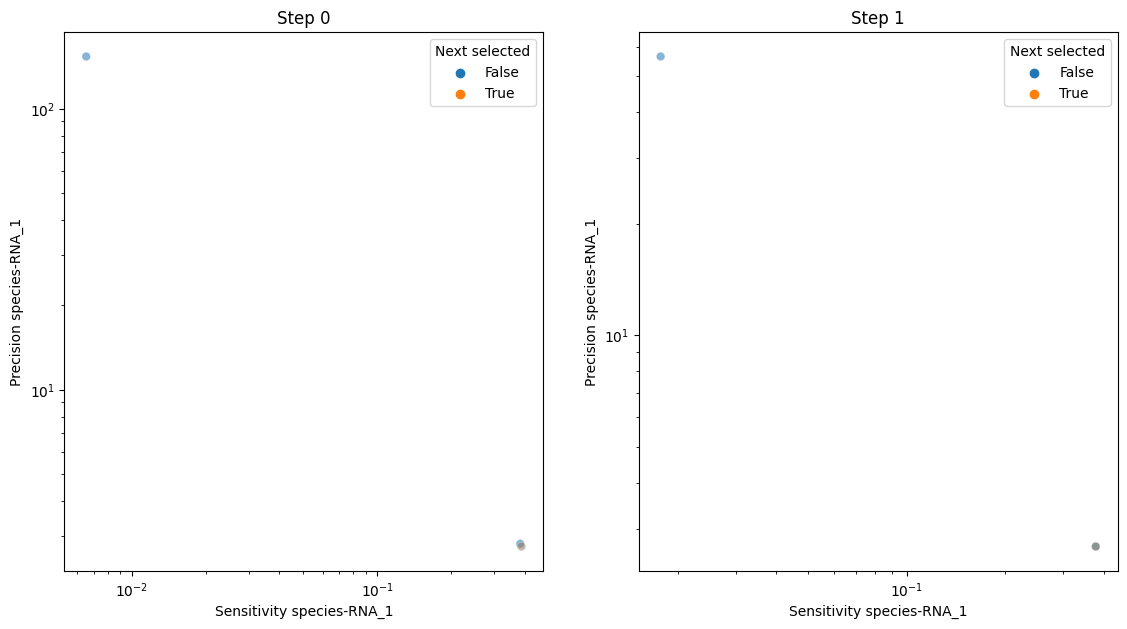

In [26]:

plt.figure(figsize=(len(summary) * 7, 7))
for step, sdata in summary_datas.items():
    ax = plt.subplot(1,len(summary), step+1)
    
    sns.scatterplot(sdata.sort_values(by=['Next selected']), x='Sensitivity species-RNA_1', y='Precision species-RNA_1', hue='Next selected', alpha=0.1)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step}')

In [38]:
data_i = summary_datas[0]
data_f = summary_datas[1]

print(f'The improvement over {total_steps} cycles was:\n')
for t in ['RNA_1', 'RNA_2']:
    print(data_i[(data_i[f'dS species-{t}'] >= 0) & (data_i[f'dP species-{t}'] >= 0)].sort_values(by=[f'Sensitivity species-{t}', f'Precision species-{t}'], ascending=False)[[f'Sensitivity species-{t}', f'Precision species-{t}']].iloc[0] - \
        data_f[(data_f[f'dS species-{t}'] >= 0) & (data_f[f'dP species-{t}'] >= 0)].sort_values(by=[f'Sensitivity species-{t}', f'Precision species-{t}'], ascending=False)[[f'Sensitivity species-{t}', f'Precision species-{t}']].iloc[0])


The improvement over 2 cycles was:

Sensitivity species-RNA_1    0.008619
Precision species-RNA_1      0.074581
dtype: float32
Sensitivity species-RNA_2       0.409027
Precision species-RNA_2     -2995.639893
dtype: float32


# Load prior experiment

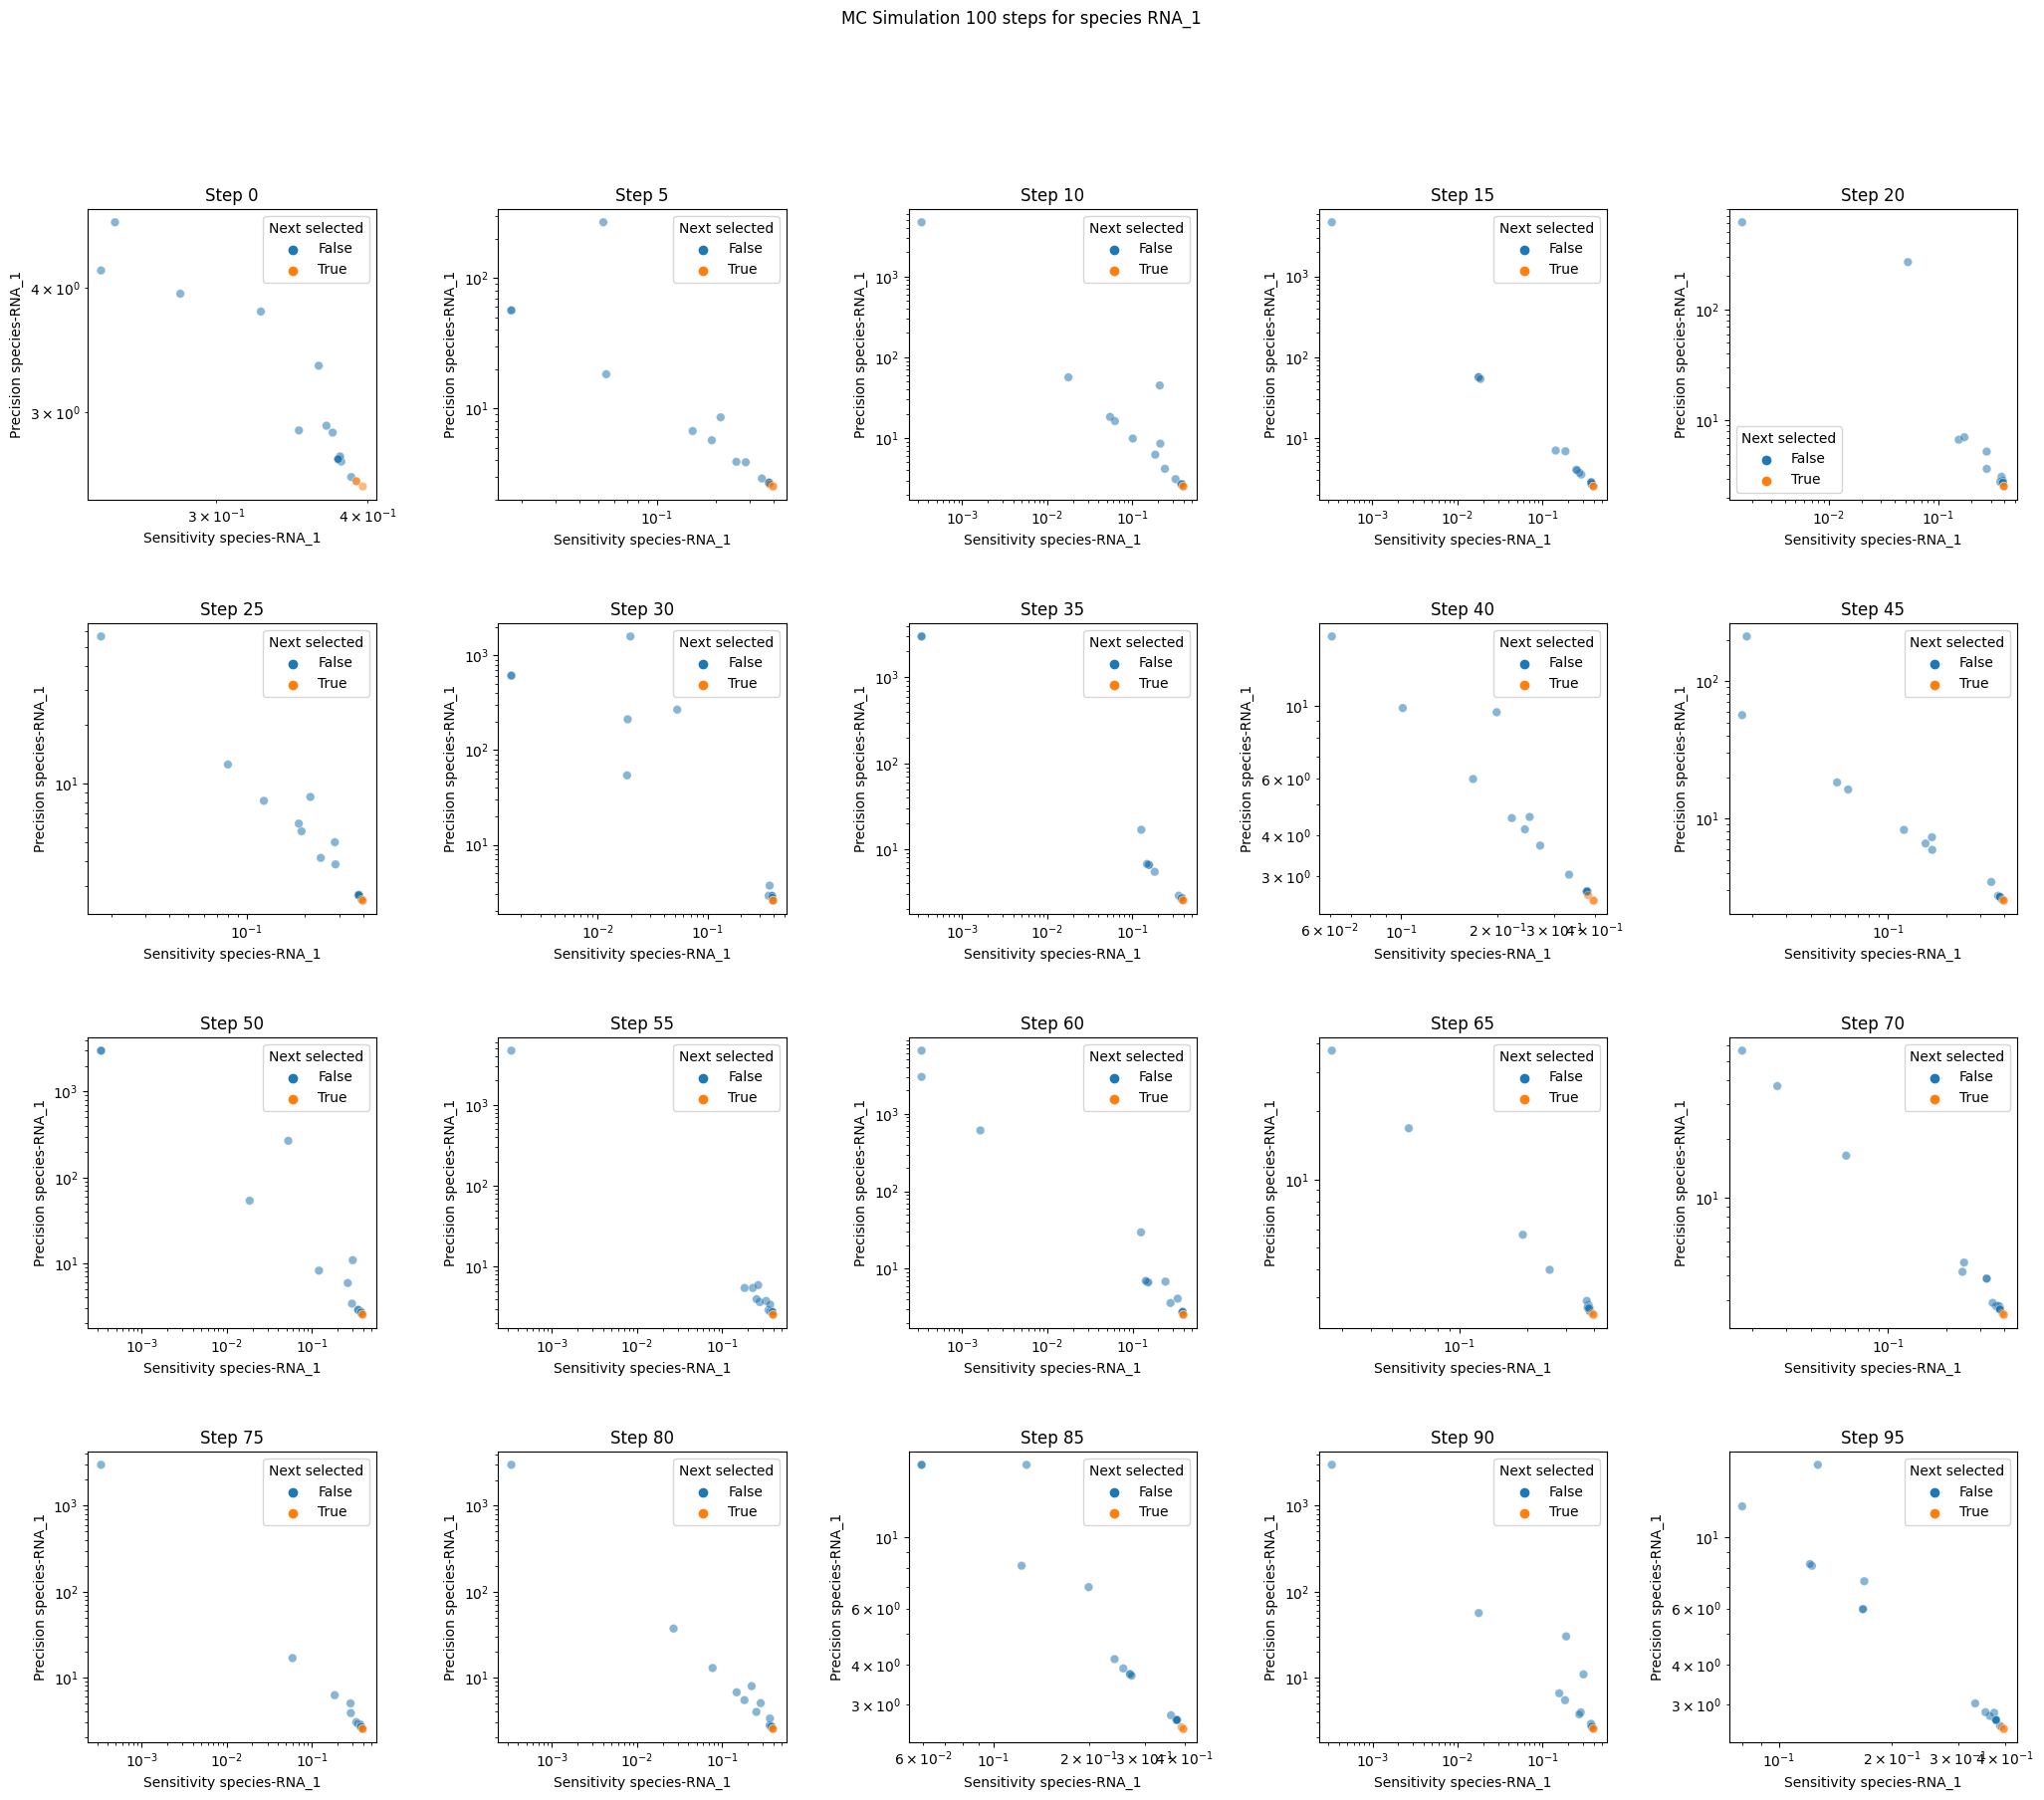

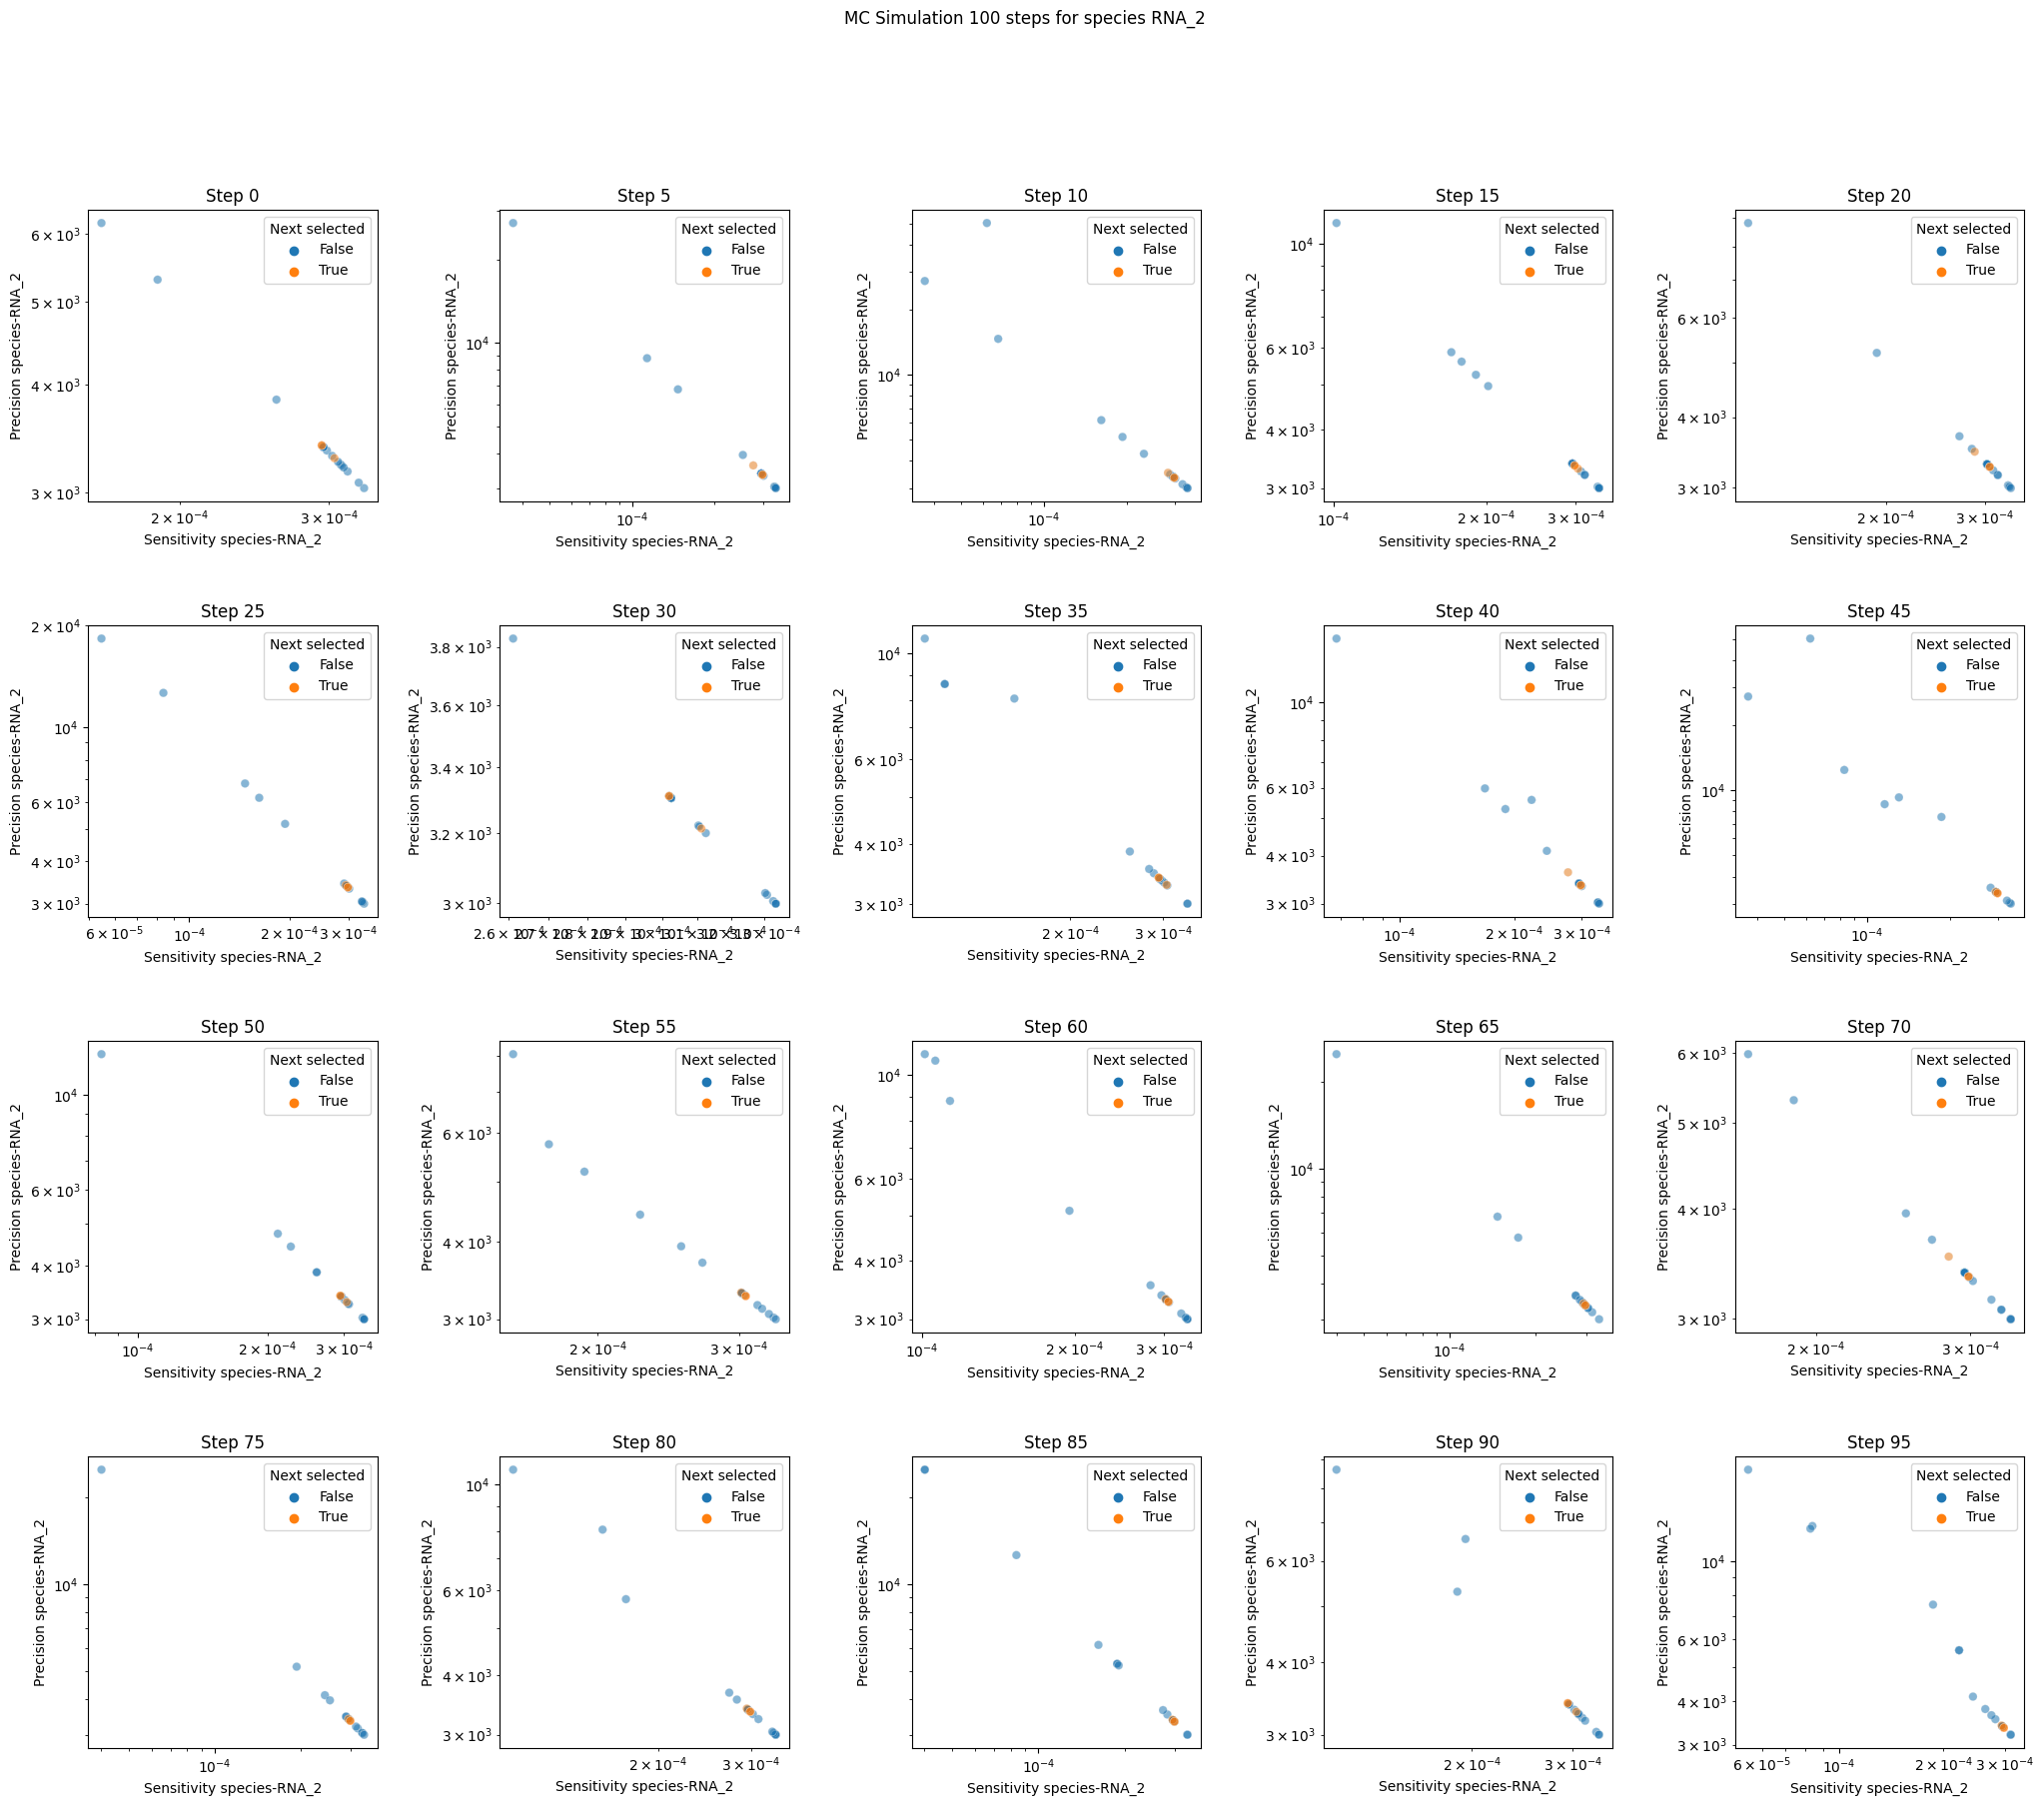

In [25]:
datas_dir = '../data/mc_evolution/2023_08_14_225542/summary_datas'

n_steps = len(os.listdir(datas_dir))
skip_every = 5
n_plots = np.sum(np.mod(np.arange(n_steps), skip_every) == 0)
n_rows = int(np.sqrt(n_plots))
n_cols = int(np.ceil(np.sqrt(n_plots)))
for species in ['RNA_1', 'RNA_2']:

    fig = plt.figure(figsize=(5*n_cols, 5*n_rows))
    fig.subplots_adjust(hspace=0.425, wspace=0.425)
    for i, sdata_fn in enumerate(os.listdir(datas_dir)):
        if np.mod(i, skip_every) != 0:
            continue
        sdata = pd.read_csv(os.path.join(datas_dir, sdata_fn))
        ax = plt.subplot(n_rows, n_cols, int(i/skip_every)+1)
        
        sns.scatterplot(sdata.sort_values(by=['Next selected']), x=f'Sensitivity species-{species}', y=f'Precision species-{species}', hue='Next selected', alpha=0.1)
        plt.xscale('log')
        plt.yscale('log')
        plt.title(f'Step {i}')
        
    plt.suptitle(f'MC Simulation {n_steps} steps for species {species}')

In [29]:
print(f'Over {n_steps} steps, the improvement was the following')
improvements = pd.concat([
    pd.read_csv(os.path.join(datas_dir, os.listdir(datas_dir)[0])).sort_values(by=[f'Sensitivity species-{species}', f'Precision species-{species}'], ascending=False).iloc[[0]],
    pd.read_csv(os.path.join(datas_dir, os.listdir(datas_dir)[-1])).sort_values(by=[f'Sensitivity species-{species}', f'Precision species-{species}'], ascending=False).iloc[[0]]])
og_cols = list(improvements.columns)
improvements['Step'] = [1, 100]
improvements = improvements[['Step'] + og_cols]
improvements.drop(columns='Circuit Obj')


Over 100 steps, the improvement was the following


,Step,Name,Subname,Sensitivity species-RNA_1,Precision species-RNA_1,Sensitivity species-RNA_2,Precision species-RNA_2,Parent Sensitivity species-RNA_1,Parent Precision species-RNA_1,dS species-RNA_1,dP species-RNA_1,Parent Sensitivity species-RNA_2,Parent Precision species-RNA_2,dS species-RNA_2,dP species-RNA_2,Next selected
119,1,toy_mRNA_circuit_10622_N_231713537538,ref_circuit,0.280063,3.948670,0.000330,3032.731,0.280063,3.948670,0.0,0.0,0.000330,3032.731,0.0,0.0,False
21,100,toy_mRNA_circuit_10622_N_013925855523,ref_circuit,0.077296,12.937266,0.000334,2998.082,0.077296,12.937266,0.0,0.0,0.000334,2998.082,0.0,0.0,False


In [20]:
sdatas = pd.DataFrame()
for i, sdata_fn in enumerate(os.listdir(datas_dir)):
    sdata = pd.read_csv(os.path.join(datas_dir, sdata_fn))
    sdatas = pd.concat([sdatas, sdata[sdata['Next selected']]])

In [22]:
sdatas['dS species-RNA_1'].value_counts()

dS species-RNA_1
0.0    2000
Name: count, dtype: int64